In [8]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.style.use(["science", "notebook", "grid"])

We wish to estimate the time it takes for a photon to travel from the Sun to the Earth. We will use the following formula:

- Generate a random walk in 3d Spherical polar coordinates
- Calculate the distance from the origin to the photon
- Get the step where the distance crosses the Earth's radius
- Use the formula:
$$ x_{rms} = \frac{\sqrt{n} \Delta x}{\sqrt{2}} $$
Where $n$ is the number of steps, $\Delta x$ is the step size, and $x_{rms}$ is the RMS distance from the origin which is essentially the radius of the Sun here.
- Calculate the total distance travelled using the formula
$$ x_{total} = n \Delta x $$
Where $n$ is the number of steps, $\Delta x$ is the step size, and $x_{total}$ is the total distance travelled.
- Hence, find the time taken for the photon to travel from the Sun to the Earth using the formula:
$$ t = \frac{x_{total}}{c} $$
Where $c$ is the speed of light and $t$ is the time taken for the photon to travel from the Sun to the Earth.

### We use the following constants:
1. Step size = $0.01$ m
2. Speed of light = $ 3 \times 10^8$ m/s
3. Radius of the Sun = $ 7 \times 10^8$ m   


In [9]:
def random_walk_spherical(n_walkers:int, n_steps:int, step_size:float):
    """ Generate random steps in 3D space.
    Parameters
    ----------
    n_walkers : int
    n_steps : int
        Number of steps to generate.
    step_size : float
        Maximum step size.
    
    Returns
    -------
    steps : (n_steps, 3) array
        Array of steps.
    """
    steps = np.zeros((n_walkers, n_steps, 3))
    theta = np.random.uniform(0, 2*np.pi, (n_walkers, n_steps))
    phi = np.random.uniform(0, np.pi, (n_walkers, n_steps))

    # Generate random steps.
    steps[:, :, 0] = step_size * np.sin(theta) * np.cos(phi)
    steps[:, :, 1] = step_size * np.sin(theta) * np.sin(phi)
    steps[:, :, 2] = step_size * np.cos(theta)

    return np.cumsum(steps, axis=1)

In [10]:
# Constants
N_WALKERS = 100
N_STEPS = 10000
STEP_SIZE = 5 # in meters
RADIUS_OF_SPHERE = 700 # in meters

# Generate random steps.
steps_spherical = random_walk_spherical(N_WALKERS, N_STEPS, STEP_SIZE)

In [11]:
def plot_path():
    fig = px.line_3d(x=steps_spherical[0, :, 0].T, y=steps_spherical[0, :, 1].T, z=steps_spherical[0, :, 2].T, 
                    width=1200, height=1000 ,
                    title=f'3D Random Walk ({N_STEPS:,} steps and {N_WALKERS:,} walkers)')

    for walker in range(1, N_WALKERS):
        fig.add_scatter3d(x=steps_spherical[walker, :, 0].T, y=steps_spherical[walker, :, 1].T, 
                        z=steps_spherical[walker, :, 2].T, 
                        marker=dict(size=.1),
                        line=dict(width=2), name=f'Walker {walker}')
    fig.add_scatter3d(x=[0], y=[0], z=[0], mode='markers', marker=dict(size=10, color='red'), name = "Origin")
    # plot_sphere(radius=1, color='blue', opacity=0.1, resolution=20)

    # Plot a sphere to represent the Sun
    resolution = 20

    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    x = RADIUS_OF_SPHERE * np.outer(np.cos(u), np.sin(v))
    y = RADIUS_OF_SPHERE * np.outer(np.sin(u), np.sin(v))
    z = RADIUS_OF_SPHERE * np.outer(np.ones(np.size(u)), np.cos(v))
    fig.add_surface(x=x, y=y, z=z, opacity=0.9)

In [12]:
# Calculate the distance from the origin.
distances_spherical = np.sqrt(np.sum(steps_spherical**2, axis=2))

# Condition to meet for the particle to be outside the sphere
condn_dist = (distances_spherical > RADIUS_OF_SPHERE)

In [13]:
steps_to_get_out = np.zeros(N_WALKERS)

# Find the step at which the condition was met
for walker in range(N_WALKERS):
    try:  # If the walker never left the sphere, np.where(condn_dist[walker, :])[0][0] will throw an IndexError
        steps_to_get_out[walker] = np.where(condn_dist[walker, :])[0][0]
    except IndexError:
        steps_to_get_out[walker] = N_STEPS # If the walker never left the sphere, 
                                            #set the step to the max number of steps

# Create a dictionary of the walker number and the step at which it got out
got_out_at = dict(zip(range(len(steps_to_get_out)), steps_to_get_out.astype(int)))

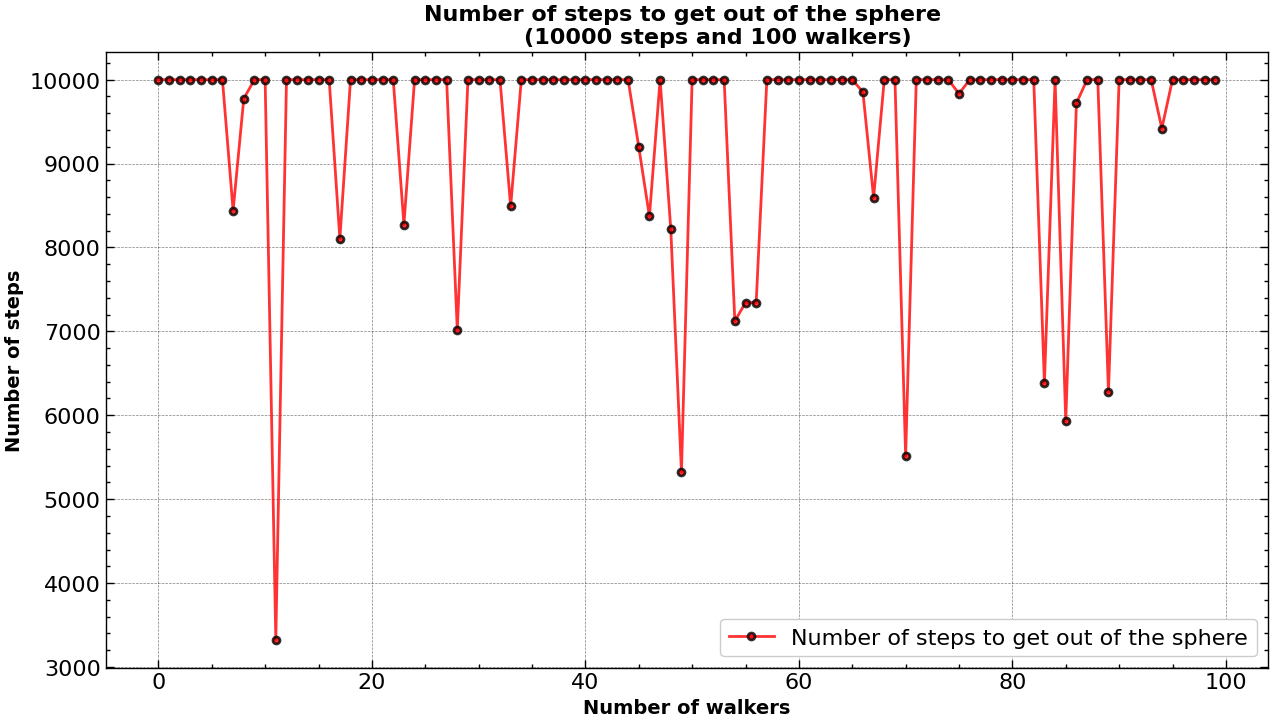

In [14]:
# Plot the number of steps to get out of the sphere
plt.figure(figsize=(15, 8))
plt.title(f"""Number of steps to get out of the sphere 
        ({N_STEPS} steps and {N_WALKERS} walkers)""", fontsize=16, fontweight='bold')
plt.xlabel('Number of walkers', fontsize=14, fontweight='bold')
plt.ylabel('Number of steps', fontsize=14, fontweight='bold')

plt.plot(got_out_at.keys(), got_out_at.values(), '-', color='red', linewidth=2, 
         label='Number of steps to get out of the sphere', alpha=0.8, marker='o', 
         markersize=5,
         markerfacecolor='red', markeredgecolor='black', markeredgewidth=2, zorder=10, 
         clip_on=False)
plt.legend()